### * Домашнее задание: Многоклассовая классификация

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin



In [2]:

import itertools
import warnings
warnings.simplefilter('ignore')

## Предобработка данных

In [5]:
# Загрузим набор данных

# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)
df = pd.read_csv('/home/mikhail/Рабочий стол/ML_BI_042020/4/freMPL-R.csv', low_memory=False)

df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

In [6]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [7]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [8]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [9]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [10]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

In [11]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [12]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [13]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [14]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [15]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [16]:
df = df.select_dtypes(exclude=['object'])

In [17]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [18]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [19]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


In [ ]:
# import plotly.express as px
# fig = px.bar(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
# fig.show()

Добавляется  признак среднего убытка, как отношение величины убытков к их частоте.

In [20]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [21]:
df['ClaimsCount']=df['ClaimsCount'].replace(to_replace = 11., value =10.) 

df['ClaimsCount'].unique()

array([ 0.,  4.,  2.,  1.,  3.,  5.,  6.,  7.,  8.,  9., 10.])

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [22]:

df['weight']= ((df['ClaimsCount'] / df['ClaimsCount'].sum())**1.2)*100000
df.loc[df.ClaimsCount.isin([0]), 'weight'] = 0.05
df.tail(10)

# df_group_count['weight'] = df_group_count['ClaimsCount'].where(df_group_count['ClaimsCount'] < 1., 1.)
# df_group_count.head()
# weights = class_weight.compute_class_weight('balanced',
#                                             df_f.ClaimsCount.unique(),
#                                              df_f.ClaimsCount)
# def make_weight (row):
#    return weights[int(row['ClaimsCount'])]
# df_f['weight'] = df_f.apply (lambda row: make_weight(row), axis=1)



,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq,ClaimsCount,weight
115145,0.500,130,1,0,34,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,1156,0.0,0.050000
115146,0.092,136,1,0,35,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,1225,0.0,0.050000
115147,0.157,352,0,0,53,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,2809,0.0,0.050000
115148,0.422,353,0,0,53,0,50,1117.886103,1,0.0,...,0,0,0,0,1,0,0,2809,1.0,0.530578
115149,0.420,358,0,0,53,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,2809,0.0,0.050000
115150,0.423,238,0,0,39,0,50,0.000000,0,4.0,...,0,0,0,0,1,0,0,1521,0.0,0.050000
115151,1.000,408,1,0,54,0,50,2764.169184,1,0.0,...,0,0,0,0,1,0,0,2916,2.0,1.218948
115152,0.805,211,0,0,35,0,54,0.000000,0,0.0,...,0,0,0,0,1,0,0,1225,0.0,0.050000
115153,0.538,356,0,0,52,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,2704,0.0,0.050000
115154,0.461,362,0,0,52,0,50,0.000000,0,0.0,...,0,0,0,0,1,0,0,2704,0.0,0.050000


## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = df.drop(columns=['Exposure', 'ClaimsCount'])
y = df['ClaimsCount']


Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [25]:
# Разбиение датасета для частоты на train/val/test

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [26]:
xgb_train = xgb.DMatrix(x_train.drop(columns=['weight']).values,
                        y_train.values,
                        weight=x_train['weight'].values)

xgb_valid = xgb.DMatrix(x_valid.drop(columns=['weight']).values,
                        y_valid.values)

xgb_test = xgb.DMatrix(x_test.drop(columns=['weight']).values,
                       y_test.values)

In [27]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': y.nunique()
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']),
                       nfold=5, metrics=['merror'], seed=21, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0]
    return score

In [28]:
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0.8, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
         'num_class': 20
        }


In [29]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [08:20<00:00, 47.79s/trial, best loss: 0.5297696000000001]


In [30]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params

{'alpha': 0.8905570299156957,
 'colsample_bytree': 0.7794023857463278,
 'eta': 0.014721920693257947,
 'lambda': 0.6668032035177822,
 'max_depth': 8,
 'min_child_weight': 24.406862661132028,
 'num_boost_round': 58.0,
 'num_class': 20,
 'subsample': 0.5792376674059414,
 'objective': 'multi:softmax'}

# Применение модели

In [31]:
progress = dict()
xgb_model = xgb.train(params=best_params, dtrain=xgb_train,
                        maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")],
                        early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

# Оценка результатов


In [32]:


dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_model.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) 
    print('Accuracy on ' + str(dfset['set'])+':', accuracy_score(dfset['target'], class_preds)) 
    print('')



F1 Score on train: 0.9357383882493053
Accuracy on train: 0.9357383882493053

F1 Score on valid: 0.931916864470561
Accuracy on valid: 0.931916864470561

F1 Score on test: 0.9319786963065879
Accuracy on test: 0.9319786963065879



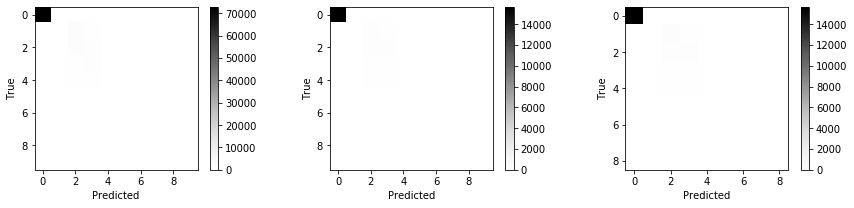

In [33]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()


Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?


Подозрительно хорошие результаты на тесте.
Где ошибка- не пойму пока.


# Drafft

In [ ]:
# pip install hyperopt

In [ ]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_model, importance_type=importance_type[0]); plt.show()

In [ ]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_model, importance_type=importance_type[0]); plt.show()

In [ ]:
!pip install eli5

In [ ]:
import eli5

In [ ]:
eli5.show_weights(xgb_model)